In [58]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt


# Path to the data directory
base_path = r"data"

# Paths to train and test data
train_inertial_path = os.path.join(base_path, "train/Inertial Signals")
test_inertial_path = os.path.join(base_path, "test/Inertial Signals")

# Function to load a single signal file
def load_signal(signal_path):
    return np.loadtxt(signal_path)

# Load all six signals for train and test data
signals = ['body_acc_x', 'body_acc_y', 'body_acc_z', 'body_gyro_x', 'body_gyro_y', 'body_gyro_z']

# Load train data
X_train_raw = np.stack([
    load_signal(os.path.join(train_inertial_path, f"{signal}_train.txt"))
    for signal in signals
], axis=-1)  # Shape: (n_samples, seq_length=128, n_features=6)

# Load test data
X_test_raw = np.stack([
    load_signal(os.path.join(test_inertial_path, f"{signal}_test.txt"))
    for signal in signals
], axis=-1)  # Shape: (n_samples, seq_length=128, n_features=6)

# Load labels
y_train_raw = pd.read_csv(f"{base_path}/train/y_train.txt", header=None, names=["activity_id"])
y_test_raw = pd.read_csv(f"{base_path}/test/y_test.txt", header=None, names=["activity_id"])

# Adjust labels to start from 0
y_train_raw['activity_id'] -= 1
y_test_raw['activity_id'] -= 1

print("Raw data shapes:")
print("X_train_raw:", X_train_raw.shape)
print("X_test_raw:", X_test_raw.shape)
print("y_train_raw:", y_train_raw.shape)
print("y_test_raw:", y_test_raw.shape)

from sklearn.model_selection import train_test_split

# Split training data into training and validation sets
X_train_raw, X_val_raw, y_train_raw, y_val_raw = train_test_split(
    X_train_raw, y_train_raw, test_size=0.2, random_state=42, stratify=y_train_raw
)

print("\nAfter splitting:")
print("Training data shape:", X_train_raw.shape)
print("Validation data shape:", X_val_raw.shape)
print("Training labels shape:", y_train_raw.shape)
print("Validation labels shape:", y_val_raw.shape)

Raw data shapes:
X_train_raw: (7352, 128, 6)
X_test_raw: (2947, 128, 6)
y_train_raw: (7352, 1)
y_test_raw: (2947, 1)

After splitting:
Training data shape: (5881, 128, 6)
Validation data shape: (1471, 128, 6)
Training labels shape: (5881, 1)
Validation labels shape: (1471, 1)


In [72]:
from scipy.signal import savgol_filter

# Apply Savitzky-Golay filter to smooth data
def apply_savgol_filter(data, window_length=11, polyorder=2):
    return savgol_filter(data, window_length=window_length, polyorder=polyorder, axis=1)

# Apply to train and test data
X_train_smooth = apply_savgol_filter(X_train_raw)
X_test_smooth = apply_savgol_filter(X_test_raw)
X_val_smooth = apply_savgol_filter(X_val_raw)

print("Savitzky-Golay smoothing applied.")



Savitzky-Golay smoothing applied.


In [73]:
from scipy.signal import medfilt

# Apply Median filter to smooth data
def apply_median_filter(data, kernel_size=3):
    smoothed_data = np.empty_like(data)
    for feature in range(data.shape[-1]):  # Apply filter feature-wise
        smoothed_data[:, :, feature] = medfilt(data[:, :, feature], kernel_size=kernel_size)
    return smoothed_data

# Apply to train and test data
X_train_median = apply_median_filter(X_train_raw, kernel_size=3)
X_test_median = apply_median_filter(X_test_raw, kernel_size=3)
X_val_median = apply_median_filter(X_val_raw, kernel_size=3)

print("Median filtering applied.")


Median filtering applied.


In [74]:
import pywt

# Apply Wavelet-Denoising
def apply_wavelet_denoising(data, wavelet='db4', level=1, threshold=0.1):
    denoised_data = np.empty_like(data)
    for feature in range(data.shape[-1]):  # Process each feature independently
        for sample in range(data.shape[0]):  # Process each sample independently
            coeffs = pywt.wavedec(data[sample, :, feature], wavelet, level=level)
            coeffs[1:] = [pywt.threshold(c, value=threshold, mode='soft') for c in coeffs[1:]]
            denoised_data[sample, :, feature] = pywt.waverec(coeffs, wavelet)[:data.shape[1]]
    return denoised_data

# Apply to train and test data
X_train_wavelet = apply_wavelet_denoising(X_train_raw)
X_test_wavelet = apply_wavelet_denoising(X_test_raw)
X_val_wavelet = apply_wavelet_denoising(X_val_raw)

print("Wavelet denoising applied.")


Wavelet denoising applied.


In [75]:
# Choose the smoothed dataset (example: Wavelet Denoising)
X_train_processed = X_train_wavelet
X_test_processed = X_test_wavelet
X_val_processed = X_val_wavelet

from sklearn.preprocessing import StandardScaler

# Flatten data for normalization
scaler = StandardScaler()
X_train_flat = X_train_processed.reshape(-1, X_train_processed.shape[-1])
X_test_flat = X_test_processed.reshape(-1, X_test_processed.shape[-1])
X_val_flat = X_val_processed.reshape(-1, X_val_processed.shape[-1])

# Fit scaler on training data and transform both train and test data
X_train_flat = scaler.fit_transform(X_train_flat)
X_test_flat = scaler.transform(X_test_flat)
X_val_flat = scaler.transform(X_val_flat)

# Reshape back to original dimensions
X_train_normalized = X_train_flat.reshape(X_train_processed.shape)
X_test_normalized = X_test_flat.reshape(X_test_processed.shape)
X_val_normalized = X_val_flat.reshape(X_val_processed.shape)

print("Data normalized.")

print("Normalized data shapes:")
print("Training:", X_train_normalized.shape)
print("Validation:", X_val_normalized.shape)
print("Test:", X_test_normalized.shape)

Data normalized.
Normalized data shapes:
Training: (5881, 128, 6)
Validation: (1471, 128, 6)
Test: (2947, 128, 6)


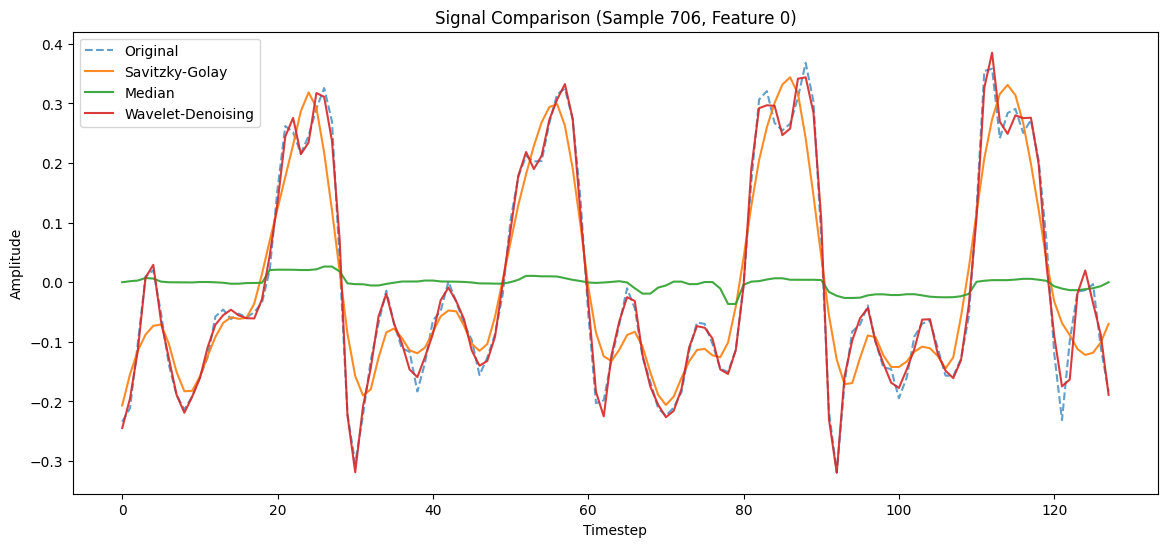

In [76]:
import matplotlib.pyplot as plt
import random

# Visualize original and filtered data for a random sample and feature
def plot_signals(original, savgol, median, wavelet, sample_idx=0, feature_idx=0):
    timesteps = original.shape[1]
    plt.figure(figsize=(14, 6))

    plt.plot(original[sample_idx, :, feature_idx], label="Original", linestyle='--', alpha=0.7)
    plt.plot(savgol[sample_idx, :, feature_idx], label="Savitzky-Golay", alpha=0.9)
    plt.plot(median[sample_idx, :, feature_idx], label="Median", alpha=0.9)
    plt.plot(wavelet[sample_idx, :, feature_idx], label="Wavelet-Denoising", alpha=0.9)

    plt.title(f"Signal Comparison (Sample {sample_idx}, Feature {feature_idx})")
    plt.xlabel("Timestep")
    plt.ylabel("Amplitude")
    plt.legend()
    plt.show()

# Choose a random sample and feature to inspect
random_sample = random.randint(0, X_train_raw.shape[0] - 1)
plot_signals(X_train_raw, X_train_smooth, X_train_median, X_train_wavelet, sample_idx=random_sample, feature_idx=0)



In [85]:
import torch
from torch.utils.data import TensorDataset, DataLoader

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train_normalized, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_raw.values, dtype=torch.long).squeeze()

X_val_tensor = torch.tensor(X_val_normalized, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val_raw.values, dtype=torch.long).squeeze()

X_test_tensor = torch.tensor(X_test_normalized, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_raw.values, dtype=torch.long).squeeze()

# Create DataLoaders
batch_size = 12
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print("DataLoaders ready!")



DataLoaders ready!


In [86]:
class EarlyStopping:
    def __init__(self, strategy="basic", patience=5, min_delta=0, save_path="best_model.pth",
                 smoothing=0.9, min_accuracy_delta=0, plateau_window=3, dynamic_patience=False):
        """
        Args:
            strategy (str): The early stopping strategy to use ("basic", "smoothing", "combined", "dynamic", "plateau").
            patience (int): Number of epochs to wait before stopping after last improvement.
            min_delta (float): Minimum improvement in validation loss to qualify as an improvement.
            save_path (str): Path to save the best model weights.
            smoothing (float): Smoothing factor for exponential moving average (only for "smoothing" strategy).
            min_accuracy_delta (float): Minimum accuracy improvement for combined strategy.
            plateau_window (int): Number of epochs to check for a plateau.
            dynamic_patience (bool): Enable dynamic adjustment of patience (only for "dynamic" strategy).
        """
        # Early Stopping Strategies:
        # 
        # 1. Basic Early Stopping: Stops training if validation loss does not improve after a specified patience.
        #    This is the simplest approach, monitoring validation loss and stopping after a set number of epochs without improvement.
        #
        # 2. Moving Average Smoothing: Uses an exponentially weighted moving average of validation loss to assess improvements.
        #    Helps smooth out fluctuations in validation loss, making it less sensitive to short-term noise in the data.
        #
        # 3. Combined Validation Loss and Accuracy: Stops training based on a combination of validation loss and accuracy.
        #    Training stops when validation loss stops improving and validation accuracy does not increase by a minimum amount.
        #
        # 4. Dynamic Patience: Adjusts patience dynamically based on improvement in validation loss.
        #    If a significant improvement in validation loss is observed, patience is increased to allow more training.
        #
        # 5. Plateau Detection: Stops training if validation loss remains within a small range (plateau) over a set window of epochs.
        #    Useful when validation loss converges within a range rather than continually decreasing.


        self.strategy = strategy
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = None
        self.best_accuracy = None
        self.counter = 0
        self.early_stop = False
        self.save_path = save_path
        self.smoothing = smoothing
        self.smoothed_loss = None
        self.min_accuracy_delta = min_accuracy_delta
        self.plateau_window = plateau_window
        self.dynamic_patience = dynamic_patience
        self.loss_history = []

    def __call__(self, val_loss, model=None, val_accuracy=None):
        if self.strategy == "basic":
            self._basic_early_stopping(val_loss, model)
        elif self.strategy == "smoothing":
            self._smoothing_early_stopping(val_loss, model)
        elif self.strategy == "combined":
            self._combined_early_stopping(val_loss, model, val_accuracy)
        elif self.strategy == "dynamic":
            self._dynamic_patience_early_stopping(val_loss, model)
        elif self.strategy == "plateau":
            self._plateau_detection_early_stopping(val_loss, model)

    def _basic_early_stopping(self, val_loss, model):
        # Basic early stopping: Stop if no improvement after patience epochs
        if self.best_loss is None or val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
            if model is not None:
                torch.save(model.state_dict(), self.save_path)
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

    def _smoothing_early_stopping(self, val_loss, model):
        # Early stopping with exponential moving average smoothing
        if self.smoothed_loss is None:
            self.smoothed_loss = val_loss
        else:
            self.smoothed_loss = self.smoothing * self.smoothed_loss + (1 - self.smoothing) * val_loss
        
        if self.best_loss is None or self.smoothed_loss < self.best_loss - self.min_delta:
            self.best_loss = self.smoothed_loss
            self.counter = 0
            if model is not None:
                torch.save(model.state_dict(), self.save_path)
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

    def _combined_early_stopping(self, val_loss, model, val_accuracy):
        # Combined strategy: Early stopping based on both validation loss and accuracy
        if (self.best_loss is None or val_loss < self.best_loss - self.min_delta or 
            (self.best_accuracy is not None and val_accuracy > self.best_accuracy + self.min_accuracy_delta)):
            self.best_loss = val_loss
            self.best_accuracy = val_accuracy
            self.counter = 0
            if model is not None:
                torch.save(model.state_dict(), self.save_path)
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

    def _dynamic_patience_early_stopping(self, val_loss, model):
        # Dynamic patience strategy: Adjust patience based on improvements
        if self.best_loss is None or val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
            if model is not None:
                torch.save(model.state_dict(), self.save_path)
            if self.dynamic_patience and val_loss < self.best_loss - 2 * self.min_delta:
                self.patience += 1
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

    def _plateau_detection_early_stopping(self, val_loss, model):
        # Plateau detection strategy: Stop if loss stays within a plateau window
        self.loss_history.append(val_loss)
        if len(self.loss_history) > self.plateau_window:
            self.loss_history.pop(0)

        if len(self.loss_history) == self.plateau_window:
            relative_changes = [
                abs(self.loss_history[i] - self.loss_history[i - 1]) / max(self.loss_history[i - 1], 1e-8)
                for i in range(1, self.plateau_window)
            ]
            if all(change < self.min_delta for change in relative_changes):
                self.counter += 1
            else:
                self.counter = 0

        if self.best_loss is None or val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
            if model is not None:
                torch.save(model.state_dict(), self.save_path)
        elif self.counter >= self.patience:
            self.early_stop = True


In [87]:
from sklearn.metrics import accuracy_score, classification_report

# Evaluate transformer model on different preprocessed datasets
def evaluate_noise_reduction_method(X_train, X_test, y_train, y_test, method_name):
    # Normalize data
    X_train_flat = X_train.reshape(-1, X_train.shape[-1])
    X_test_flat = X_test.reshape(-1, X_test.shape[-1])
    
    scaler = StandardScaler()
    X_train_normalized = scaler.fit_transform(X_train_flat).reshape(X_train.shape)
    X_test_normalized = scaler.transform(X_test_flat).reshape(X_test.shape)
    
    # Convert to tensors
    X_train_tensor = torch.tensor(X_train_normalized, dtype=torch.float32)
    X_test_tensor = torch.tensor(X_test_normalized, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train.values, dtype=torch.long).squeeze()
    y_test_tensor = torch.tensor(y_test.values, dtype=torch.long).squeeze()
    
    # Create DataLoaders
    batch_size = 64
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    # Train and evaluate the transformer
    model = HARTransformer(input_dim=6, seq_length=128, num_classes=6).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()
    
    # Training loop
    num_epochs = 10
    for epoch in range(num_epochs):
        model.train()
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
    
    # Evaluate on test data
    model.eval()
    all_labels, all_preds = [], []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())
    
    accuracy = accuracy_score(all_labels, all_preds)
    print(f"Accuracy ({method_name}): {accuracy:.2f}")
    print(classification_report(all_labels, all_preds, target_names=['WALKING', 'WALKING_UPSTAIRS', 
                                                                     'WALKING_DOWNSTAIRS', 'SITTING', 
                                                                     'STANDING', 'LAYING']))
    return accuracy

# Evaluate each method
accuracy_savgol = evaluate_noise_reduction_method(X_train_smooth, X_test_smooth, y_train_raw, y_test_raw, "Savitzky-Golay")
accuracy_median = evaluate_noise_reduction_method(X_train_median, X_test_median, y_train_raw, y_test_raw, "Median")
accuracy_wavelet = evaluate_noise_reduction_method(X_train_wavelet, X_test_wavelet, y_train_raw, y_test_raw, "Wavelet")


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Accuracy (Savitzky-Golay): 0.71
                    precision    recall  f1-score   support

           WALKING       0.94      0.74      0.83       496
  WALKING_UPSTAIRS       0.91      0.85      0.88       471
WALKING_DOWNSTAIRS       0.75      1.00      0.85       420
           SITTING       0.64      0.06      0.10       491
          STANDING       0.48      0.84      0.61       532
            LAYING       0.72      0.78      0.75       537

          accuracy                           0.71      2947
         macro avg       0.74      0.71      0.67      2947
      weighted avg       0.73      0.71      0.67      2947



/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Accuracy (Median): 0.42
                    precision    recall  f1-score   support

           WALKING       0.52      0.76      0.62       496
  WALKING_UPSTAIRS       0.00      0.00      0.00       471
WALKING_DOWNSTAIRS       0.47      0.74      0.58       420
           SITTING       0.00      0.00      0.00       491
          STANDING       0.34      0.98      0.51       532
            LAYING       0.75      0.05      0.09       537

          accuracy                           0.42      2947
         macro avg       0.35      0.42      0.30      2947
      weighted avg       0.35      0.42      0.29      2947



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transfo

Accuracy (Wavelet): 0.65
                    precision    recall  f1-score   support

           WALKING       0.88      0.83      0.86       496
  WALKING_UPSTAIRS       0.85      0.87      0.86       471
WALKING_DOWNSTAIRS       0.94      0.96      0.95       420
           SITTING       0.39      0.01      0.03       491
          STANDING       0.40      0.54      0.46       532
            LAYING       0.48      0.74      0.58       537

          accuracy                           0.65      2947
         macro avg       0.66      0.66      0.62      2947
      weighted avg       0.64      0.65      0.61      2947



In [ ]:
class HARTransformer(nn.Module):
    def __init__(self, input_dim, seq_length, num_classes, d_model=128, nhead=8, num_layers=4, dropout=0.1):
        super(HARTransformer, self).__init__()
        # Embedding for hver funktion
        self.embedding = nn.Linear(input_dim, d_model)
        self.positional_encoding = nn.Parameter(torch.zeros(1, seq_length, d_model))  # Positional encoding

        # Transformer Encoder
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dropout=dropout)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # Classification layer
        self.fc = nn.Linear(d_model, num_classes)

    def forward(self, x):
        # x: (batch_size, seq_length, input_dim)
        x = self.embedding(x) + self.positional_encoding  # Add positional encoding
        x = self.transformer(x)  # Transformer encoder
        x = x.mean(dim=1)  # Pooling: Mean over timesteps
        x = self.fc(x)  # Classification layer
        return x


# Initialiser transformer
input_dim = 6  # 3 accelerometer + 3 gyroscope
seq_length = 128
num_classes = 6  # Activities

d_model = 128  # Embedding-dimension
nhead = 8  # Number of attention heads
num_layers = 4  # Number of transformer layers
dropout = 0.1  # Dropout for regulering
learning_rate = 0.5e-5#1e-4  # Learning rate
num_epochs = 200

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device: ",device)

model = HARTransformer(input_dim=input_dim, seq_length=seq_length, num_classes=num_classes,
                       d_model=d_model, nhead=nhead, num_layers=num_layers, dropout=dropout).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)



device:  cuda


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [89]:

# Create a directory to save epoch plots if it doesn't already exist
if not os.path.exists("epoch_plots_transformer"):
    os.makedirs("epoch_plots_transformer")

# Automatically get optimizer, model, and criterion names
optimizer_name = type(optimizer).__name__
model_name = type(model).__name__
criterion_name = type(criterion).__name__

train_losses = []
val_losses = []
val_accuracies = []

# Variable to keep track of the best validation accuracy and its epoch
best_val_accuracy = 0
best_epoch = 0

# Variable to keep track of the previous epoch's filename
prev_epoch_filename = None

# Choose an early stopping strategy and define the patience, min_delta, and strategy type
early_stopping = EarlyStopping(strategy="combined", patience=10, min_delta=0.001, save_path="best_model_transformer.pth") # patience=5

for epoch in range(num_epochs):
    # Training loop
    model.train()
    epoch_train_loss = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_train_loss += loss.item()

    # Calculate average training loss for the epoch
    epoch_train_loss /= len(train_loader)
    train_losses.append(epoch_train_loss)
    
    # Validation loop
    model.eval()
    epoch_val_loss = 0
    correct, total = 0, 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            val_loss = criterion(outputs, labels)
            epoch_val_loss += val_loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    # Calculate average validation loss for the epoch
    epoch_val_loss /= len(val_loader)
    val_losses.append(epoch_val_loss)
    
    # Validation accuracy
    val_accuracy = 100 * correct / total
    val_accuracies.append(val_accuracy)
    
    # Check if this is the best validation accuracy
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        best_epoch = epoch + 1
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {epoch_train_loss:.4f}, Validation Loss: {epoch_val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")
    
    # Plot and save the training and validation loss for each epoch
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, epoch + 2), train_losses, label="Training Loss")
    plt.plot(range(1, epoch + 2), val_losses, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(f"Loss over Epochs (Epoch {epoch+1})")
    plt.legend()

    # Mark the best validation accuracy on the plot
    plt.annotate(f'Best Val Acc: {best_val_accuracy:.2f}% (Epoch {best_epoch})',
                 xy=(best_epoch, val_losses[best_epoch - 1]),
                 xytext=(best_epoch, val_losses[best_epoch - 1] + 0.02),
                 arrowprops=dict(arrowstyle="->", color="red"),
                 fontsize=8, color="red")
    
    # Model details for the box below the plot
    model_info = (
        f"Model Name: {model_name}\n"
        f"Optimizer: {optimizer_name}\n"
        f"Criterion: {criterion_name}\n"
        f"Learning Rate: {learning_rate}\n"
        f"Epochs: {num_epochs}\n"
        f"Batch size: {batch_size}\n\n"
        f"Model structure: {model}\n"
    )

    # Add text box with model information below the plot
    plt.gcf().text(0.5, -0.2, model_info, ha="center", va="center", fontsize=8, bbox=dict(facecolor='lightgrey', alpha=0.5))

    # Define the filename for the current epoch
    current_epoch_filename = f"epoch_plots_transformer/loss_epoch_{epoch+1}.png"
    
    # Save the plot for the current epoch
    plt.savefig(current_epoch_filename, bbox_inches='tight')
    plt.close()  # Close the plot to free memory
    
    # Delete the previous epoch's plot if it exists
    if prev_epoch_filename and os.path.exists(prev_epoch_filename):
        os.remove(prev_epoch_filename)
    
    # Update the previous epoch filename to the current one
    prev_epoch_filename = current_epoch_filename

    # Call early stopping and break if triggered
    early_stopping(epoch_val_loss, model, val_accuracy)
    if early_stopping.early_stop:
        print("Early stopping triggered")
        break

# Load the best model weights after training if early stopping was triggered
if early_stopping.early_stop:
    model.load_state_dict(torch.load("best_model_transformer.pth"))
    print(f"Loaded the best model weights from epoch {best_epoch} with validation accuracy: {best_val_accuracy:.2f}%")



Epoch [1/200], Training Loss: 1.4538, Validation Loss: 1.1634, Validation Accuracy: 47.59%
Epoch [2/200], Training Loss: 1.1209, Validation Loss: 1.0559, Validation Accuracy: 56.29%
Epoch [3/200], Training Loss: 1.0412, Validation Loss: 0.9910, Validation Accuracy: 58.33%
Epoch [4/200], Training Loss: 0.9785, Validation Loss: 0.9359, Validation Accuracy: 56.56%
Epoch [5/200], Training Loss: 0.9281, Validation Loss: 0.8823, Validation Accuracy: 61.45%
Epoch [6/200], Training Loss: 0.8816, Validation Loss: 0.8448, Validation Accuracy: 60.77%
Epoch [7/200], Training Loss: 0.8455, Validation Loss: 0.8129, Validation Accuracy: 60.77%
Epoch [8/200], Training Loss: 0.8161, Validation Loss: 0.7835, Validation Accuracy: 63.49%
Epoch [9/200], Training Loss: 0.7902, Validation Loss: 0.7746, Validation Accuracy: 63.70%
Epoch [10/200], Training Loss: 0.7755, Validation Loss: 0.7444, Validation Accuracy: 63.90%
Epoch [11/200], Training Loss: 0.7580, Validation Loss: 0.7331, Validation Accuracy: 64.0

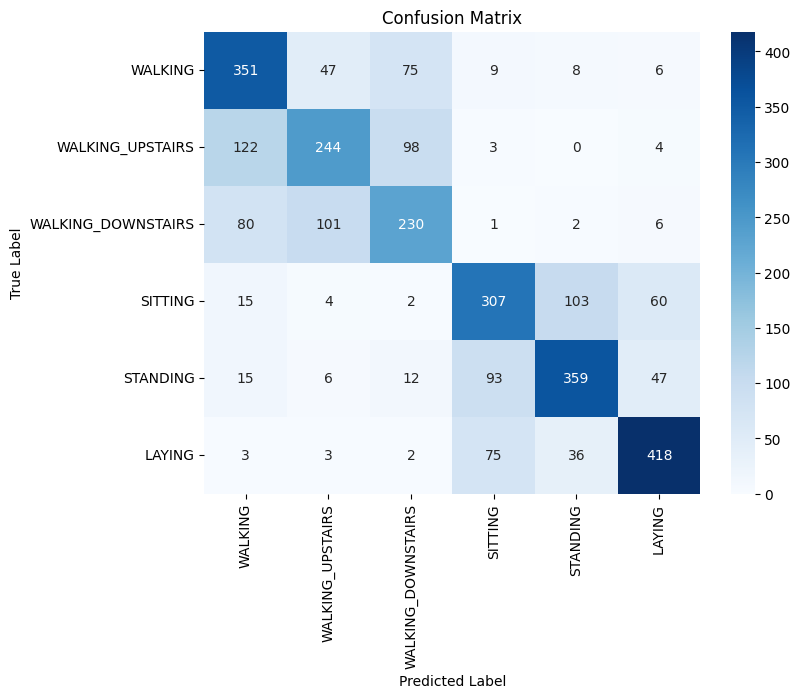

Accuracy: 0.65

Classification Report:
                    precision    recall  f1-score   support

           WALKING       0.60      0.71      0.65       496
  WALKING_UPSTAIRS       0.60      0.52      0.56       471
WALKING_DOWNSTAIRS       0.55      0.55      0.55       420
           SITTING       0.63      0.63      0.63       491
          STANDING       0.71      0.67      0.69       532
            LAYING       0.77      0.78      0.78       537

          accuracy                           0.65      2947
         macro avg       0.64      0.64      0.64      2947
      weighted avg       0.65      0.65      0.65      2947


Macro Precision: 0.64
Macro Recall: 0.64
Macro F1 Score: 0.64

Micro Precision: 0.65
Micro Recall: 0.65
Micro F1 Score: 0.65


In [56]:

from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score

# Initialize lists for actual and predicted labels
all_labels = []
all_preds = []

# Evaluation loop to collect predictions and actual labels
model.eval()
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        
        # Add actual and predicted labels to the lists
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())

# Compute the confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)

# Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=['WALKING', 'WALKING_UPSTAIRS', 'WALKING_DOWNSTAIRS', 'SITTING', 'STANDING', 'LAYING'],
            yticklabels=['WALKING', 'WALKING_UPSTAIRS', 'WALKING_DOWNSTAIRS', 'SITTING', 'STANDING', 'LAYING'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# Compute overall accuracy
accuracy = accuracy_score(all_labels, all_preds)
print(f"Accuracy: {accuracy:.2f}")

# Compute precision, recall, and F1-score for each class
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=['WALKING', 'WALKING_UPSTAIRS', 
                                                                 'WALKING_DOWNSTAIRS', 'SITTING', 
                                                                 'STANDING', 'LAYING']))

# Compute macro and micro average scores
macro_precision = precision_score(all_labels, all_preds, average='macro')
macro_recall = recall_score(all_labels, all_preds, average='macro')
macro_f1 = f1_score(all_labels, all_preds, average='macro')

micro_precision = precision_score(all_labels, all_preds, average='micro')
micro_recall = recall_score(all_labels, all_preds, average='micro')
micro_f1 = f1_score(all_labels, all_preds, average='micro')

print(f"\nMacro Precision: {macro_precision:.2f}")
print(f"Macro Recall: {macro_recall:.2f}")
print(f"Macro F1 Score: {macro_f1:.2f}")

print(f"\nMicro Precision: {micro_precision:.2f}")
print(f"Micro Recall: {micro_recall:.2f}")
print(f"Micro F1 Score: {micro_f1:.2f}")
